# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.341057,True,6.094884
1,-0.943988,False,-1.859987
2,-1.766549,False,-1.022965
3,-0.464593,False,0.422382
4,-0.261416,False,-1.621774
...,...,...,...
995,-0.329988,False,-0.209193
996,0.805815,True,6.587458
997,-1.119123,False,-1.468974
998,-0.408043,True,5.182579


<AxesSubplot: xlabel='v0'>

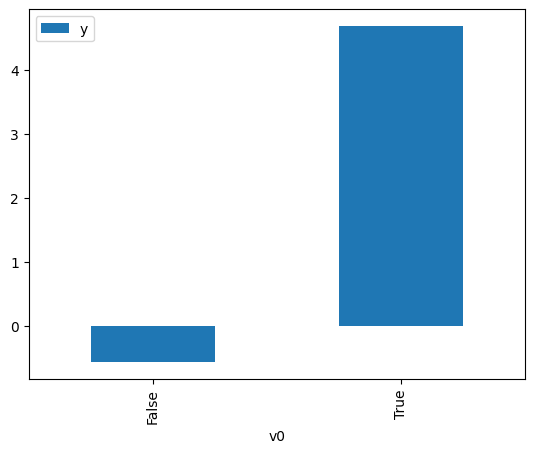

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

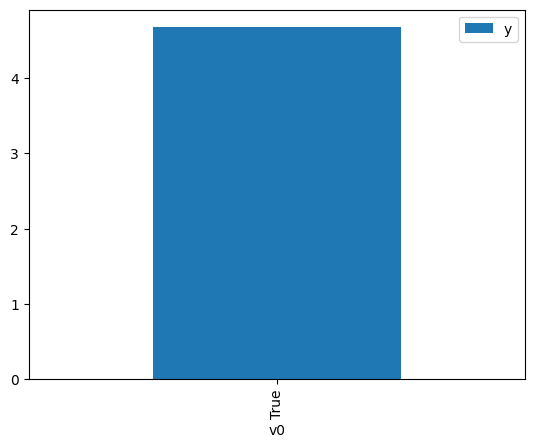

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.769552,False,0.232160,0.882444,1.133216
1,-0.080220,False,0.963311,0.553210,1.807633
2,-0.761956,False,0.866193,0.880368,1.135888
3,0.976475,False,1.734305,0.072501,13.792896
4,-1.705102,False,-1.058246,0.988588,1.011544
...,...,...,...,...,...
995,0.331263,False,-0.076957,0.296900,3.368133
996,-0.400450,False,-1.711298,0.740934,1.349647
997,-1.771990,False,-2.270971,0.990401,1.009692
998,-3.945902,False,-2.235685,0.999967,1.000033


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.254981,True,3.877408,0.036095,27.704859
1,-1.157749,True,6.051899,0.046060,21.710710
2,2.769125,True,5.811220,0.999280,1.000721
3,-1.159571,True,3.510571,0.045851,21.809591
4,-1.476568,True,4.869829,0.020550,48.662571
...,...,...,...,...,...
995,0.550957,True,7.005650,0.807904,1.237770
996,-0.389819,True,4.151224,0.264436,3.781630
997,-1.157749,True,6.051899,0.046060,21.710710
998,-0.866293,True,2.712128,0.093749,10.666750


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.863
Model:                            OLS   Adj. R-squared (uncentered):              0.863
Method:                 Least Squares   F-statistic:                              3145.
Date:                Tue, 25 Oct 2022   Prob (F-statistic):                        0.00
Time:                        18:27:15   Log-Likelihood:                         -1427.6
No. Observations:                1000   AIC:                                      2859.
Df Residuals:                     998   BIC:                                      2869.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5725      0.023     24.555      0.000       0.527       0.618
x2             5.0086      0.068     73.573      0.000       4.875       5.142
==============================================================================
Omnibus:                        3.421   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                3.862
Skew:                           0.013   Prob(JB):                        0.145
Kurtosis:                       3.303   Cond. No.                         2.93
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""